# Questão 01: 
Considere os dados "banknote authentication Data Set" do site uci machine learning repository
(https://archive.ics.uci.edu/ml/datasets/banknote+authentication#).
Normalize os dados.
Execute o algoritmo "Variable-wise kernel fuzzyc-means clustering algorithms with kernelization of
the metric" 100 vezes para obter uma partição fuzzy em 2 grupos e selecione o melhor resultado
segundo a função objetivo.



## Equações

### **Kernel Gaussiano:** 

A idéia é Kernelizar a métrica de distância. Assim, para cada cluster $i \in \{1,2\}$ calcularemos para cada componente $j \in \{1,...,p\}$, já que o dataset tem $p$ váriáveis, da seguinte maneira:

$$K_j(x_{kj}, v_{ij}) = e^{-\frac{(x_{kj} - v_{ij})^2}{2\sigma_j^2}}, \sigma_j > 0$$ 

Onde o termo $2\sigma_j^2$ pode ser estimado como a média dos quantis 0.1 e 0.9 de $(x_{ij} - x_{kj})^2, i \neq k.$ 

Assim, com $p = 4$:

$K(\mathbf{x_{k}}, \mathbf{v_{i}}) = [K(x_{k1}, v_{i1}), K(x_{k2}, v_{i2}), K(x_{k3}, v_{i3}), K(x_{k4}, v_{i4})]$

Neste caso, haverá dois vetores  $K(\mathbf{x_{k}}, \mathbf{v_{i}})$: 

$K(\mathbf{x_{k}}, \mathbf{v_{1}})$, para o centróide 1 e  

$K(\mathbf{x_{k}}, \mathbf{v_{2}})$ para o centróide 2.



### **Distância adaptativa:**

$$\varphi^2(\mathbf{x_k}, \mathbf{v_i}) = \sum_{j=1}^{p} \lambda_{ij} 2(1 - K(x_{kj}, v_{ij}))$$

Com $\lambda_{ij} > 0 ~~~ \forall i, j$  e  $\prod_{j=1}^p \lambda_{ij} = 1 $.


### **Função objetivo:**

$$J = \sum_{i=1}^c \sum_{k=1}^n (u_{ik})^m \varphi^2(x_k, v_i) $$

Onde $c$ é o número de clusters e $n$ é o número de instâncias.

### **Atualização dos centróides $v_{ij}$:**

O centróide $\mathbf{v_i} = (v_{i1},..., v_{ip})$, tem seus componentes calculados de acordo com a seguinte expressão:


$$v_{ij} = \frac{\sum_{k=1}^n (u_{ik})^m K(x_{kj}, v_{ij})x_{kj}}{\sum_{k=1}^n (u_{ik})^m K(x_{kj}, v_{ij})} $$

### **Atualização dos pesos $\lambda_{ij}$:**

$$\lambda_{ij} = \frac{\{\prod_{l=1}^p (\sum_{k=1}^n (u_{ik})^m 2(1 - K(x_{kl}, v_{il})))\}^{1/p}}{\sum_{k=1}^n (u_{ik})^m 2(1 - K(x_{kj}, v_{ij}))} $$

### **Atualização do grau de pertinência $u_{ik}$:**

$$u_{ik} = \Big[\sum_{h=1}^c \big( \frac{\varphi^2(\mathbf{x_k}, \mathbf{v_i})}{\varphi^2(\mathbf{x_k}, \mathbf{v_h})} \big)^{\frac{1}{m-1}}  \Big]^{-1} $$

In [1]:
import pandas as pd
import math as mt
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from collections import Counter
from random import sample
from random import randint
from copy import deepcopy
from scipy.linalg import norm
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score

## Importando os dados:






In [2]:
cols = ['x1','x2', 'x3', 'x4', 'class']
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header=None, names=cols)

In [3]:
df.head()

,x1,x2,x3,x4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
Counter(df['class'])

Counter({0: 762, 1: 610})

## Pré-Processamento

In [5]:
# Normalização usando o MinMax
scaler = MinMaxScaler(feature_range=(0.00001, 1.00001))
df[['x1','x2', 'x3', 'x4']] = scaler.fit_transform(df[['x1','x2', 'x3', 'x4']])

# Imputando média em lugar de valores faltantes (se houver):
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[['x1','x2','x3','x4']] = imp_mean.fit_transform(df[['x1','x2','x3','x4']])

X = df[df.columns[:-1]]
y = df[df.columns[[-1]]]

In [6]:
X=np.asarray(X)
print(X)

[[0.76901389 0.83965273 0.10679269 0.73663766]
 [0.83566902 0.82099209 0.12181412 0.64433563]
 [0.78663859 0.41665827 0.31061805 0.78696091]
 ...
 [0.23739543 0.01177814 0.98561321 0.52476518]
 [0.25085193 0.20171105 0.76159701 0.6606845 ]
 [0.32453819 0.49075676 0.34335762 0.88595888]]


In [7]:
np.isnan(np.sum(X))

False

## Implementação do Algoritmo



Variable-wise kernel fuzzy c-means clustering algorithms with kernelization of the metric (VKFCM_K_LP). Página 7 do artigo!




In [8]:
#implementação do algoritmo
class VKFCM_K_LP():
    """Parameters
    ----------
    n_clusters: int, optional (default=2)
        The number of clusters to form as well as the number of
        centroids to generate
    max_iter: int, optional (default=100)
        Hard limit on iterations within solver.
    m: float, optional (default=1.1)
        Exponent for the fuzzy partition matrix, specified as a
        scalar greater than 1.0. This option controls the amount of
        fuzzy overlap between clusters, with larger values indicating
        a greater degree of overlap.
    error: float, optional (default=1e-10)
        Tolerance for stopping criterion.
    random_state: int, optional (default=42)
        Determines random number generation for centroid initialization. Use
        an int to make the randomness deterministic.
    Attributes
    ----------
    n_samples: int
        Number of examples in the data set
    n_features: int
        Number of features in samples of the data set
    u: array, shape = [n_samples, n_clusters]
        Fuzzy partition array, returned as an array with n_samples rows
        and n_clusters columns. Element u[i,j] indicates the degree of
        membership of the jth data point in the ith cluster. For a given
        data point, the sum of the membership values for all clusters is one.
    v: array, shape = [n_class-1, n_SV]
        Final cluster centers, returned as an array with n_clusters rows
        containing the coordinates of each cluster center. The number of
        columns in centers is equal to the dimensionality of the data being
        clustered.
    random_state: int, optional (default=42)
        Determines random number generation for centroid initialization. Use
        an int to make the randomness deterministic."""
    def __init__(self, n_clusters=2, max_iter=150, m=1.1, error=(10**(-10)), random_state=42):
        #Parametros: c = 2; m = {1:1; 1:6; 2:0}; T = 150;  error= 10^−10;
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state
        self.lam = None
        self.v = None
        self.u = None
        self.j = None
        self.dois_sig_quad = None
    
    def plot_centroids(self):
      plt.scatter(df[['x1']],df[['x2']],c=df[['class']].to_numpy())
      c1 = self.v[0]
      c2 = self.v[1]
      plt.scatter(c1[0], c1[1], c = 'red')
      plt.scatter(c2[0], c2[1], c = 'green') 
      plt.show()

    def fit(self, X):
        # Passo (1) do algoritmo do artigo, pág. 10:
        self.n_features = X.shape[1]
        self.n_samples = X.shape[0]
        self.calcular_centroides(X, random=True)
        self.calcular_lambda(X, random=True)
        self.calcular_u(X, random=True) 
        self.calcular_2sigma_quad(X)
        #self.plot_centroids()

        j_anterior = 0
        for t in range(self.max_iter): #Passo (2)
          #print(f't = {t}, ', end = '')
          self.calcular_centroides(X, random=False) #Passo (3) 
          self.calcular_lambda(X, random=False) #Passo (4)
          self.calcular_u(X, random=False) #Passo (5)
          #Passo (6)
          j = self.J(X)
          #print(f'J= {j}')
          if abs(j - j_anterior) <= self.error:
            self.j = j
            return None # Dúvida: o que o fit deve retornar? os graus de pertinência self.u ?
          j_anterior = j
          self.j = j
          #if t%5 == 0: self.plot_centroids()

    def predict(self, X):
      y_pred = []
      for k in range(self.n_samples):
        best = self.u[0][k]
        best_index = 0
        for i in range(self.n_clusters):
          if self.u[i][k] > best:
            best_index = i
            best = self.u[i][k]
        y_pred.append(best_index) # Verificar o que deve ser colocado no y_pred.
      return y_pred

    def K(self, x_k, v_i): #Função kernel, o erro está vindo daqui!
      retorno = []
      for j in range(self.n_features): #percorre as colunas
        retorno.append(np.exp(-(np.power(x_k[j]-v_i[j], 2))/(self.dois_sig_quad[j])))
      return retorno


    def varphi_quad(self, x_k, v_i, lam_i): #Recebe uma instância e um dos centróides. Calcula a distância kernelizada entre os dois.
      soma = 0
      for j in range(self.n_features): #percorre as colunas
        soma += lam_i[j]*2*(1 - self.K(x_k, v_i)[j])
      return soma

    def J(self, X):
      soma = 0
      for i in range(self.n_clusters): #percorre os clusters
        for k in range(self.n_samples): #percorre as linhas
          soma += np.power(self.u[i][k], self.m)*self.varphi_quad(X[k], self.v[i], self.lam[i])
      return soma
    
    
    def calcular_centroides(self, X, random):
      #print('função calcular_centroides { ', end ='')
      if random:
        offset = [0.1, -0.1, 0.1, -0.1]
        self.v = [X[randint(0,self.n_samples)] + offset, X[randint(0,self.n_samples)] - offset]  
        #print('Centróides aleatórios: ', self.v)
        return self.v
      else:
        for i in range(self.n_clusters): #percorre os clusters
          for j in range(self.n_features): #percorre as colunas
            numerador = 0
            denominador = 0
            #print('j = ', j)
            for k in range(self.n_samples): #percorre as linhas
              numerador +=  ((self.u[i][k]**self.m) * (self.K(X[k], self.v[i])[j])) * X[k][j]
            for k in range(self.n_samples): #percorre as linhas
              denominador += (self.u[i][k]**self.m) * (self.K(X[k], self.v[i])[j])
            self.v[i][j] = numerador/(denominador)
      #print('Centróides: ', self.v)
      #print(' }')
      return self.v 
      

    def calcular_lambda(self, X, random):
      #print('funcao calcular_lambda { ', end ='')
      if random:
        self.lam=np.ones((self.n_clusters, self.n_features))
      else:
        for i in range(self.n_clusters):
          numerador = 1
          p = self.n_features
          for l in range(p): #percorre as colunas 
            soma_do_numerador = 0
            for k in range(self.n_samples): #percorre as linhas
              soma_do_numerador += np.power(self.u[i][k], self.m)*2*(1- self.K(X[k],self.v[i])[l])
            numerador *= soma_do_numerador
          numerador = np.power(numerador, 1/p)
          for j in range(p): #percorre as colunas
            denominador = 0
            for k in range(self.n_samples):
              denominador += np.power(self.u[i][k], self.m)*2*(1- self.K(X[k],self.v[i])[j])
            self.lam[i][j] = numerador/(denominador)
      #print('Lambda: ', self.lam) 
      #print(' }')
      return self.lam

    def calcular_u(self, X, random): #inicialização da partição fuzzy, calcula os graus de pertinência(u_{ik})
        #print('funcao calcular_u {', end ='')
        if random:
          rnd = np.random.RandomState(self.random_state)
          self.u = rnd.rand(self.n_samples, self.n_clusters)
          soma = self.u.sum(axis=1).reshape(-1,1)
          denominador = np.repeat(soma,self.n_clusters,axis=1)
          self.u = (self.u/(denominador)).T #Transpondo para ficar com dimensões (n_clusters, n_features) e podermos acessar u[i][k]
        else:
            for i in range(self.n_clusters):
              for k in range(self.n_samples): 
                soma = 0 
                numerador = self.varphi_quad(X[k], self.v[i], self.lam[i]) # Isso pode ser calculado fora do próximo for, pois não depende de h
                for h in range(self.n_clusters):
                  #soma += np.power((self.varphi_quad(X[k], self.v[i], self.lam[i]) / (self.varphi_quad(X[k], self.v[h], self.lam[h]))), (1/(self.m - 1)))
                  soma += np.power((numerador / (self.varphi_quad(X[k], self.v[h], self.lam[h]))), (1/(self.m - 1)))  # Assim fica mais rápido e dá o mesmo resultado.
                result = np.power(soma,(-1)) 
                self.u[i][k] = result
            #print('u',self.u)
        #print('}')
        return self.u


    def calcular_2sigma_quad(self, X): #Calcula $2\sigma^2$, essa função é chamada uma única vez.
      retorno=[]
      for j in range(self.n_features):
        dif = np.subtract.outer(X[:,j], X[:,j])
        retorno.append(np.mean(np.quantile(dif[dif > 0]**2, [0.1, 0.9])))
      #print('2sigma_quad', retorno)
      self.dois_sig_quad = retorno
      return retorno

    #coeficientes Modified partition coefficient e o Partition entropy
    def PartEntropy(self):
      PE = 0
      for i in range(self.n_clusters):
        for k in range(self.n_samples):
          PE += self.u[i][k] * (mt.log(self.u[i][k])/self.n_samples)
      return -PE
    def PartCoef(self):
      PC = 0
      for i in range(self.n_clusters):
        for k in range(self.n_samples):
          PC += (self.u[i][k])**2 /self.n_samples
      return PC
    def ModPartCoef(self):
      MPC = 1 - self.n_clusters/(self.n_clusters-1)*(1-self.PartCoef())
      return MPC

    def partCrisp(self, X):
      ''' Retorna a lista de objetos por grupos  em um dict. Ex.: {0: [ ], 1: []} '''
      particoes = { i:[] for i in range(self.n_clusters)}
      y_pred = self.predict(X)
      for k in range(self.n_samples):
          particoes[y_pred[k]].append(X[k])
      return particoes
    
        

In [9]:
def f_measure(y_true, y_pred):
  contingency_matrix = np.zeros(shape=(2,2), dtype=int)
  n_samples = len(y_pred)
  n_clusters = len(np.unique(y_pred))
  n_classes = len(np.unique(y_true))
  
  for i in range(n_samples):
    if   y_pred[i] == 0 and y_true[i] == 0:
      contingency_matrix[0,0] += 1
    elif y_pred[i] == 0 and y_true[i] == 1:
      contingency_matrix[0,1] += 1
    elif y_pred[i] == 1 and y_true[i] == 0:
      contingency_matrix[1,0] += 1
    elif y_pred[i] == 1 and y_true[i] == 1:
      contingency_matrix[1,1] += 1
  
  n = contingency_matrix
  soma_col = [0,0]
  soma_lin = [0,0]
  soma_col[0] =  n[0,0] +  n[1,0] #soma da coluna 0 = n.0
  soma_col[1] =  n[0,1] +  n[1,1] #soma da coluna 1 = n.1
  soma_lin[0] =  n[0,0] +  n[0,1] #soma da linha 0 = n0.
  soma_lin[1] =  n[1,1] +  n[1,0] #soma da linha 1 = n1.

  F_measure = 0
  for j in range(n_classes):
    a_maximizar = []
    for i in range(n_clusters):
      numerador = (n[i,j]*n[i,j])/(soma_lin[i]*soma_col[j])
      denominador = (n[i,j]/(soma_lin[i])) + (n[i,j]/(soma_col[j]))
      a_maximizar.append(numerador/denominador)
    maximo = np.max(a_maximizar)
    F_measure += (soma_col[j]/n_samples) * maximo
  F_measure *= 2
  return F_measure

In [31]:
def main():
  results = {1.1: None, 1.6: None, 2.0: None} #Guardará o resultado do melhor modelo (entre os 100) para cada m.
  for m in [1.1, 1.6, 2.0]:
    print(f'\nExecutando algoritmo com m = {m}')
    objective = []
    models = [] #precisamos guardar cada modelo também, já que depois teremos que calcular várias coisas para o melhor.
    n_repet = 100 #Precisa ser 100
    for i in range(n_repet):
      print('.', end='') 
      vkfcm_k_lp = VKFCM_K_LP(max_iter=150, m=m)   #max_iter precisa ser 150
      vkfcm_k_lp.fit(X)
      objective.append(vkfcm_k_lp.j)
      models.append(vkfcm_k_lp)

    
    index_array = np.argmin(objective, axis=-1)   #index da função objetivo com menor valor
    #print(f'*** Parâmetros do melhor modelo entre os {n_repet}: ***')
    J = objective[index_array]
    #print('Função Objetivo:', J)
    best_model = models[index_array]
    #print('Graus de pertinência u:', best_model.u)
    v = best_model.v
    #print('(i) Protótipos (centróides): ', v)
    particoes = best_model.partCrisp(X)
    objs_cluster_0 = particoes[0]
    objs_cluster_1 = particoes[1]
    num_objs_0 = len(particoes[0])
    num_objs_1 = len(particoes[1])
    #print('(ii) Partições crisp: ')
    #print('Objetos do cluster 0: ', objs_cluster_0)
    #print('Objetos do cluster 1: ', objs_cluster_1)
    #print('(iii) número de objetos de cada partição crisp:')
    #print('Núm de objetos do cluster 0: ', num_objs_0)
    #print('Núm de objetos do cluster 1: ', num_objs_1)
    mpc = best_model.ModPartCoef()
    #print("(iv) Modified Partition Coefficient:", mpc)
    pe = best_model.PartEntropy()
    #print("(iv) Partition Entropy:", pe)
    #print("(v) Métricas: ")
    y_pred = best_model.predict(X)
    y_true = np.asarray(y)
    f_meas = f_measure(y_true, y_pred)
    #print('F-measure = ', f_meas)
    erro = 1 - np.max([accuracy_score(y_true, y_pred), accuracy_score(y_true, [(pred-1)**2 for pred in y_pred]) ])  #considera a possibilidade de predições invertidas.
    #print('Erro de classificação = ', erro )
    ars = adjusted_rand_score(y_true.ravel(), y_pred)
    #print('Adjusted Rand Score = ', ars)

    # Guardando um dicionário para armazenar os resultados do melhor modelo para este valor de m:
    results[m] = {'J':J, 'v': v, 'objs_cluster_0':objs_cluster_0, 'objs_cluster_1': objs_cluster_1, 
            'num_objs_0':num_objs_0, 'num_objs_1': num_objs_1, 'MPC': mpc, 'PE': pe, 
            'F-measure': f_meas, 'Erro': erro, 'ARS': ars, 'u':best_model.u}

  return results, best_model


In [32]:
resultados, best_model = main()


Executando algoritmo com m = 1.1
....................................................................................................
Executando algoritmo com m = 1.6
....................................................................................................
Executando algoritmo com m = 2.0
....................................................................................................

In [66]:
#sns.kdeplot(data=resultados[1.1]['u'][0], shade=True)

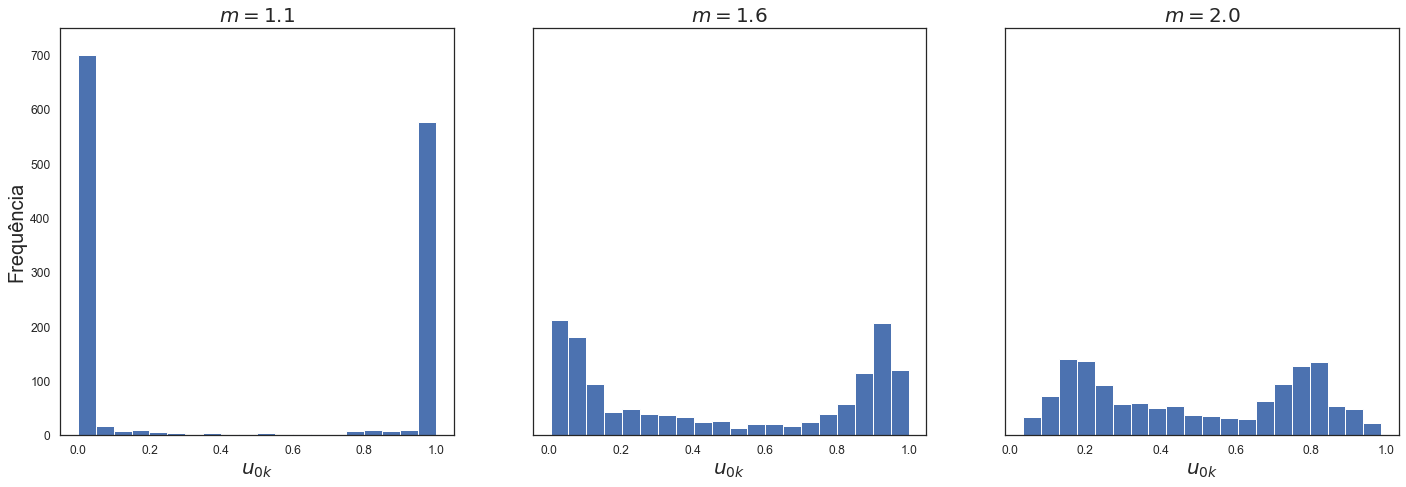

In [104]:
#histogramas para o grupo 0
#plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,7.5))
i = 0
axes = axes.flatten()
pos = 0
for m in [1.1, 1.6, 2.0]:
    axes[pos].hist(resultados[m]['u'][i], bins = 20)
    axes[pos].set_ylim(0,750)
    axes[pos].set_title(f'$m = {m}$', size=20)
    if pos == 0: axes[pos].set_ylabel('Frequência', fontsize=20)
    axes[pos].set_xlabel('$u_{0k}$', fontsize=20);
    pos += 1
plt.savefig('histogramas_u0k.png')

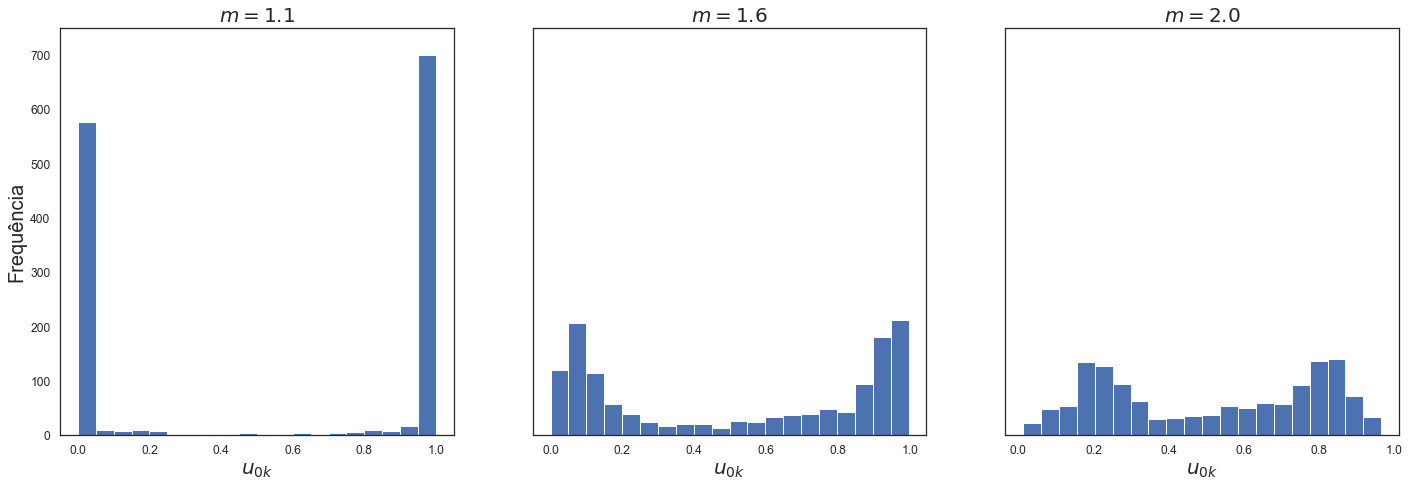

In [103]:
#histogramas para o grupo 1
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,7.5))
i = 1
axes = axes.flatten()
pos = 0
for m in [1.1, 1.6, 2.0]:
    axes[pos].hist(resultados[m]['u'][i], bins = 20)
    axes[pos].set_ylim(0,750)
    axes[pos].set_title(f'$m = {m}$', size=20)
    if pos == 0: axes[pos].set_ylabel('Frequência', fontsize=20)
    axes[pos].set_xlabel('$u_{0k}$', fontsize=20);
    pos += 1
plt.savefig('histogramas_u1k.png')

In [36]:
print(resultados[1.1]['J'])
print(resultados[1.6]['J'])
print(resultados[2.0]['J'])

1548.297973916541
1374.3780335872975
1127.7134873957498


In [37]:
tab_metricas = pd.DataFrame({'m': [1.1, 1.6, 2.0],
                            #'Núm objs cluster 0': [resultados[1.1]['num_objs_0'], resultados[1.6]['num_objs_0'], resultados[2.0]['num_objs_0']],
                            #'Núm objs cluster 1': [resultados[1.1]['num_objs_1'], resultados[1.6]['num_objs_1'], resultados[2.0]['num_objs_1']],
                            'MPC':                [resultados[1.1]['MPC'],        resultados[1.6]['MPC'],        resultados[2.0]['MPC']],
                            'PE':                 [resultados[1.1]['PE'],         resultados[1.6]['PE'],         resultados[2.0]['PE']],
                            'F-measure':          [resultados[1.1]['F-measure'],  resultados[1.6]['F-measure'],  resultados[2.0]['F-measure']],
                            'Erro':               [resultados[1.1]['Erro'],       resultados[1.6]['Erro'],       resultados[2.0]['Erro']],
                            'ARS':                [resultados[1.1]['ARS'],        resultados[1.6]['ARS'],        resultados[2.0]['ARS']]
                            })
tab_metricas.to_csv('tab_metricas.csv', index=False, float_format='%.4f')
tab_metricas

,m,MPC,PE,F-measure,Erro,ARS
0,1.1,0.955280,0.037864,0.583346,0.416910,0.026804
1,1.6,0.573730,0.350280,0.581565,0.419096,0.025412
2,2.0,0.314457,0.519755,0.579687,0.421283,0.024048


In [38]:
# Criando um dicionário para armazenar os objetos de cada cluster. Será acessado assim:  objs_clusters[m][número do cluster]
objs_clusters = {1.1: {0: None, 1: None}, 1.6: {0: None, 1: None}, 2.0: {0: None, 1: None} }
for m in [1.1, 1.6, 2.0]:
  for i in [0,1]:
    objs_cluster_i_dict = {'x1': [], 'x2': [], 'x3': [], 'x4': []}
    for obj in resultados[m]['objs_cluster_'+str(i)]:
      #print(obj)
      objs_cluster_i_dict['x1'].append(obj[0])
      objs_cluster_i_dict['x2'].append(obj[1])
      objs_cluster_i_dict['x3'].append(obj[2])
      objs_cluster_i_dict['x4'].append(obj[3])

    objs_clusters[m][i] = pd.DataFrame(objs_cluster_i_dict)

In [39]:
objs_clusters[1.1][0].to_csv('objs_cluster0_m_1.1.csv') 
objs_clusters[1.1][1].to_csv('objs_cluster1_m_1.1.csv') 
objs_clusters[1.6][0].to_csv('objs_cluster0_m_1.6.csv') 
objs_clusters[1.6][1].to_csv('objs_cluster1_m_1.6.csv') 
objs_clusters[2.0][0].to_csv('objs_cluster0_m_2.0.csv') 
objs_clusters[2.0][1].to_csv('objs_cluster1_m_2.0.csv') 

In [40]:
objs_clusters[2.0][0] # Essa é a tabela de objetos do cluster 0 com m=1.1.

,x1,x2,x3,x4
0,0.769014,0.839653,0.106793,0.736638
1,0.835669,0.820992,0.121814,0.644336
2,0.757115,0.871709,0.054931,0.450450
3,0.822869,0.877285,0.057110,0.489721
4,0.738841,0.730866,0.195269,0.721587
...,...,...,...,...
643,0.063391,0.841280,0.218413,0.446803
644,0.512614,0.608604,0.101072,0.720764
645,0.490001,0.587852,0.121336,0.704068
646,0.351588,0.574999,0.229670,0.624704


In [41]:
print('Número de objetos de cada grupo: ')
for m in [1.1, 1.6, 2.0]:
  for i in [0,1]:
    print(f'm = {m}, i = {i}, {objs_clusters[m][i].shape[0]}')

Número de objetos de cada grupo: 
m = 1.1, i = 0, 618
m = 1.1, i = 1, 754
m = 1.6, i = 0, 633
m = 1.6, i = 1, 739
m = 2.0, i = 0, 648
m = 2.0, i = 1, 724


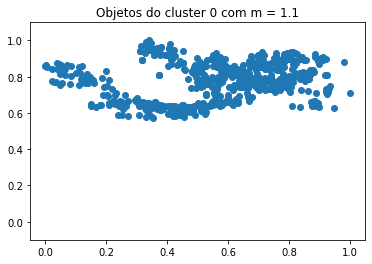

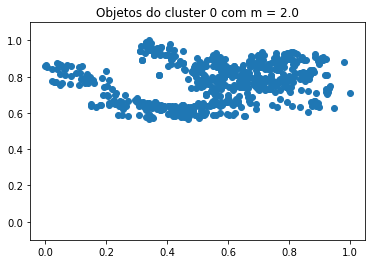

In [43]:
plt.scatter(objs_clusters[1.1][0]['x1'], objs_clusters[1.1][0]['x2'])
plt.title('Objetos do cluster 0 com m = 1.1')
plt.ylim(-0.1,1.1)
plt.show()
plt.close('all')

plt.scatter(objs_clusters[2.0][0]['x1'], objs_clusters[2.0][0]['x2'])
plt.title('Objetos do cluster 0 com m = 2.0')
plt.ylim(-0.1,1.1)
plt.show()
plt.close('all')


In [52]:
prot_dict = {'$m$':[],'Grupo':[],'$x_1$':[],'$x_2$':[],'$x_3$':[],'$x_4$':[]}
for m in [1.1, 1.6, 2.0]:
    for grupo in [0,1]:
        prot_dict['$m$'].append(m)
        prot_dict['Grupo'].append(grupo)
        for p in range(4):
            prot_dict[f'$x_{p+1}$'].append(resultados[m]['v'][grupo][p])

prot_df = pd.DataFrame(prot_dict) 
prot_df.to_csv('tab_prototipos.csv',index=False, float_format='%.7f')
prot_df

,$m$,Grupo,$x_1$,$x_2$,$x_3$,$x_4$
0,1.1,0,0.582815,0.776722,0.157570,0.547624
1,1.1,1,0.514968,0.450053,0.358866,0.789264
2,1.6,0,0.590512,0.769820,0.158947,0.556366
3,1.6,1,0.506815,0.444454,0.366208,0.789456
4,2.0,0,0.596127,0.762709,0.163264,0.574866
5,2.0,1,0.501310,0.449773,0.361032,0.786995


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/dis

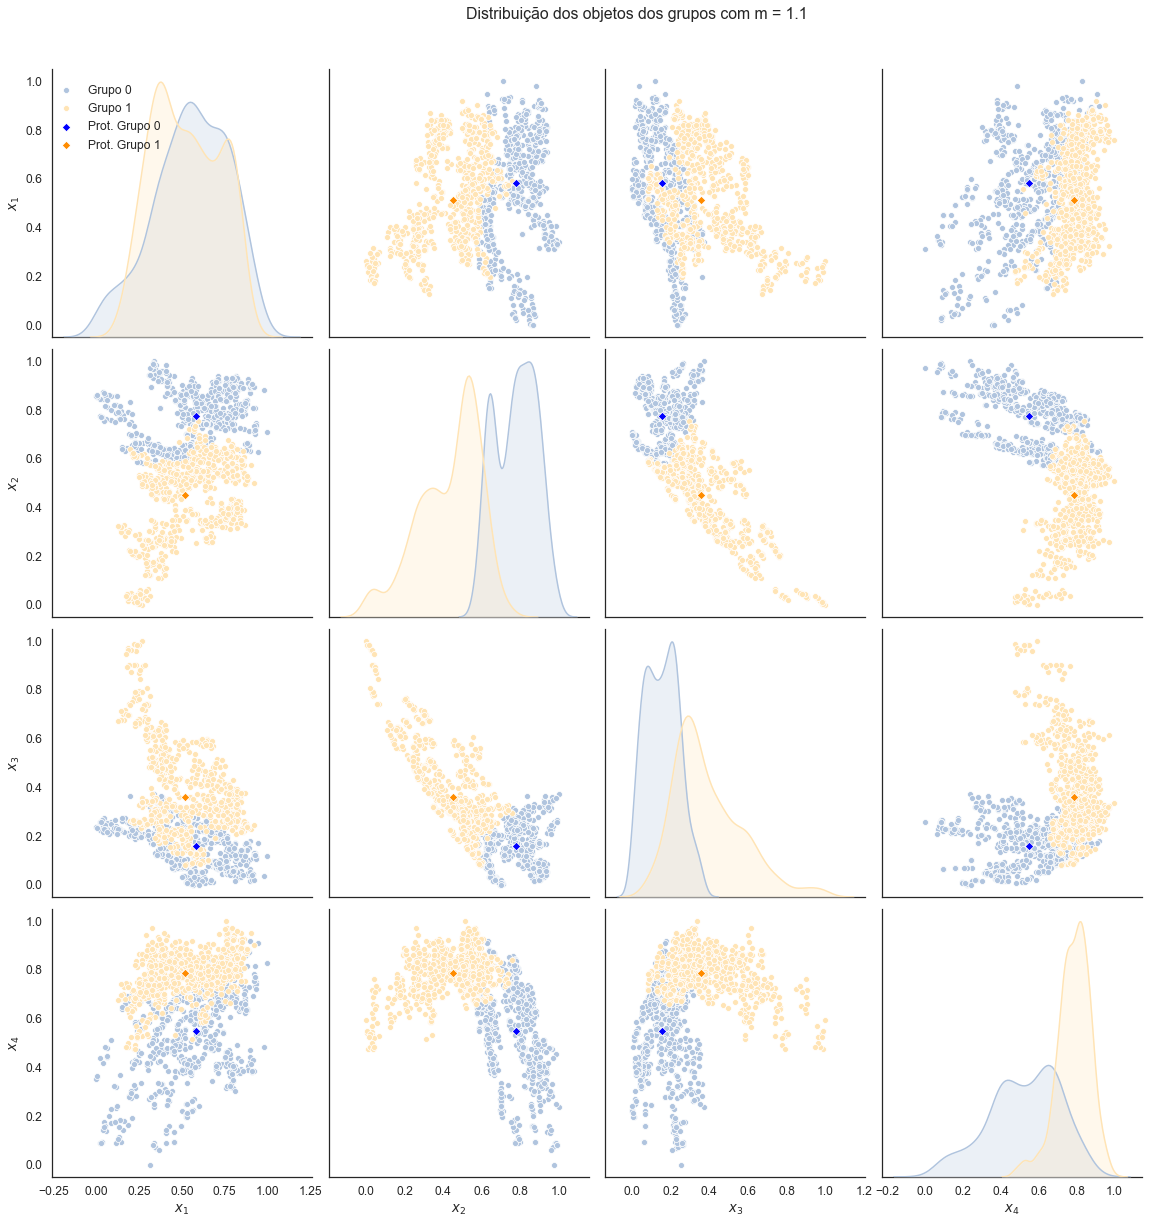

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/dis

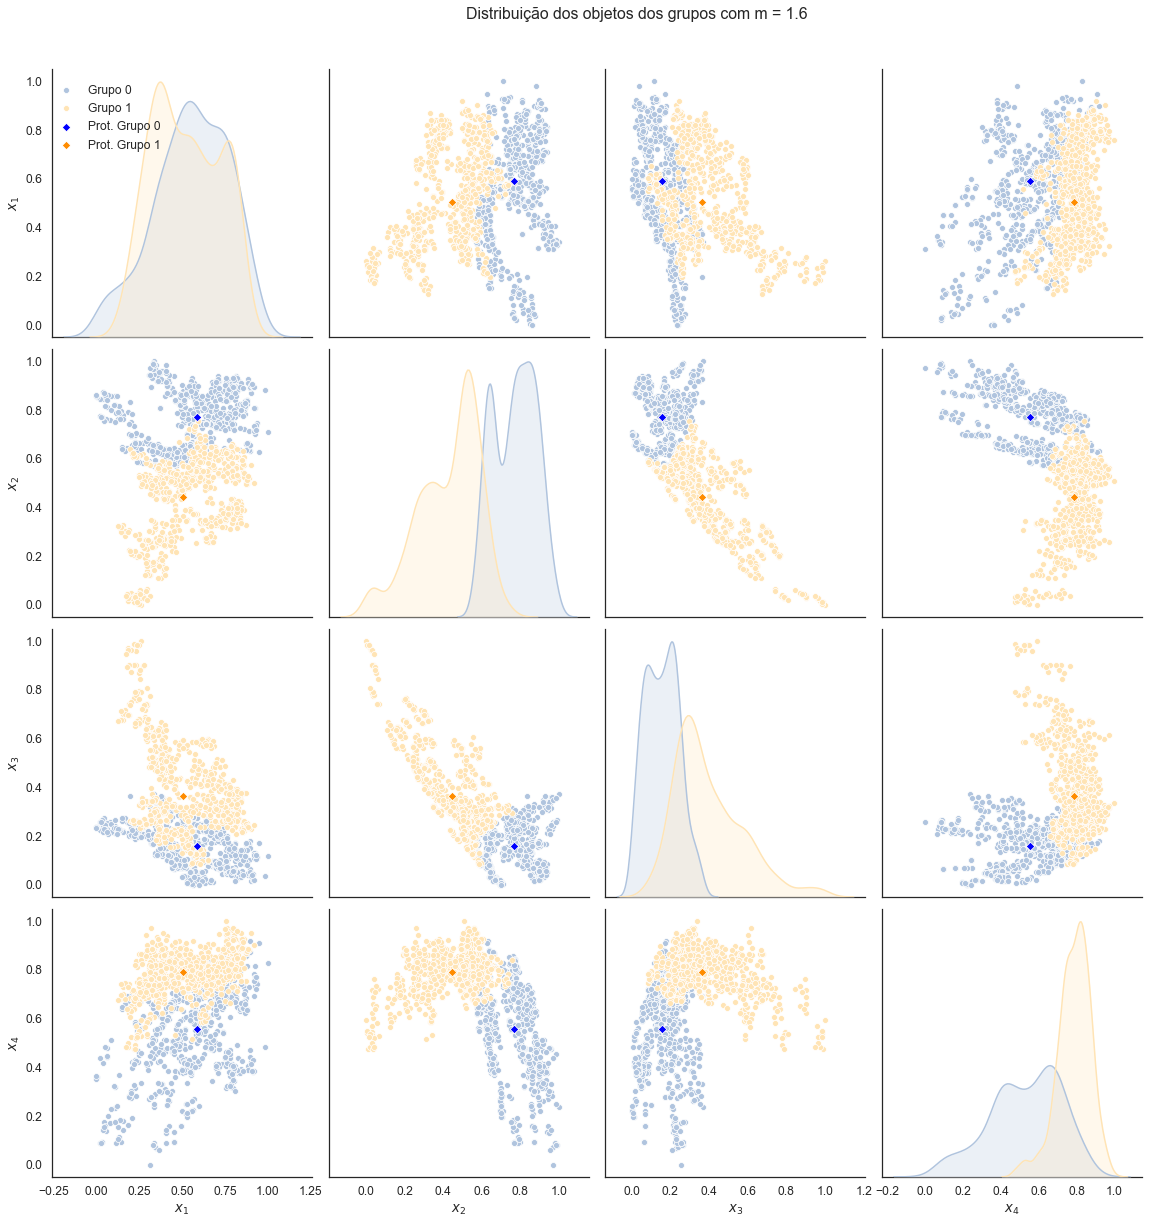

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/dis

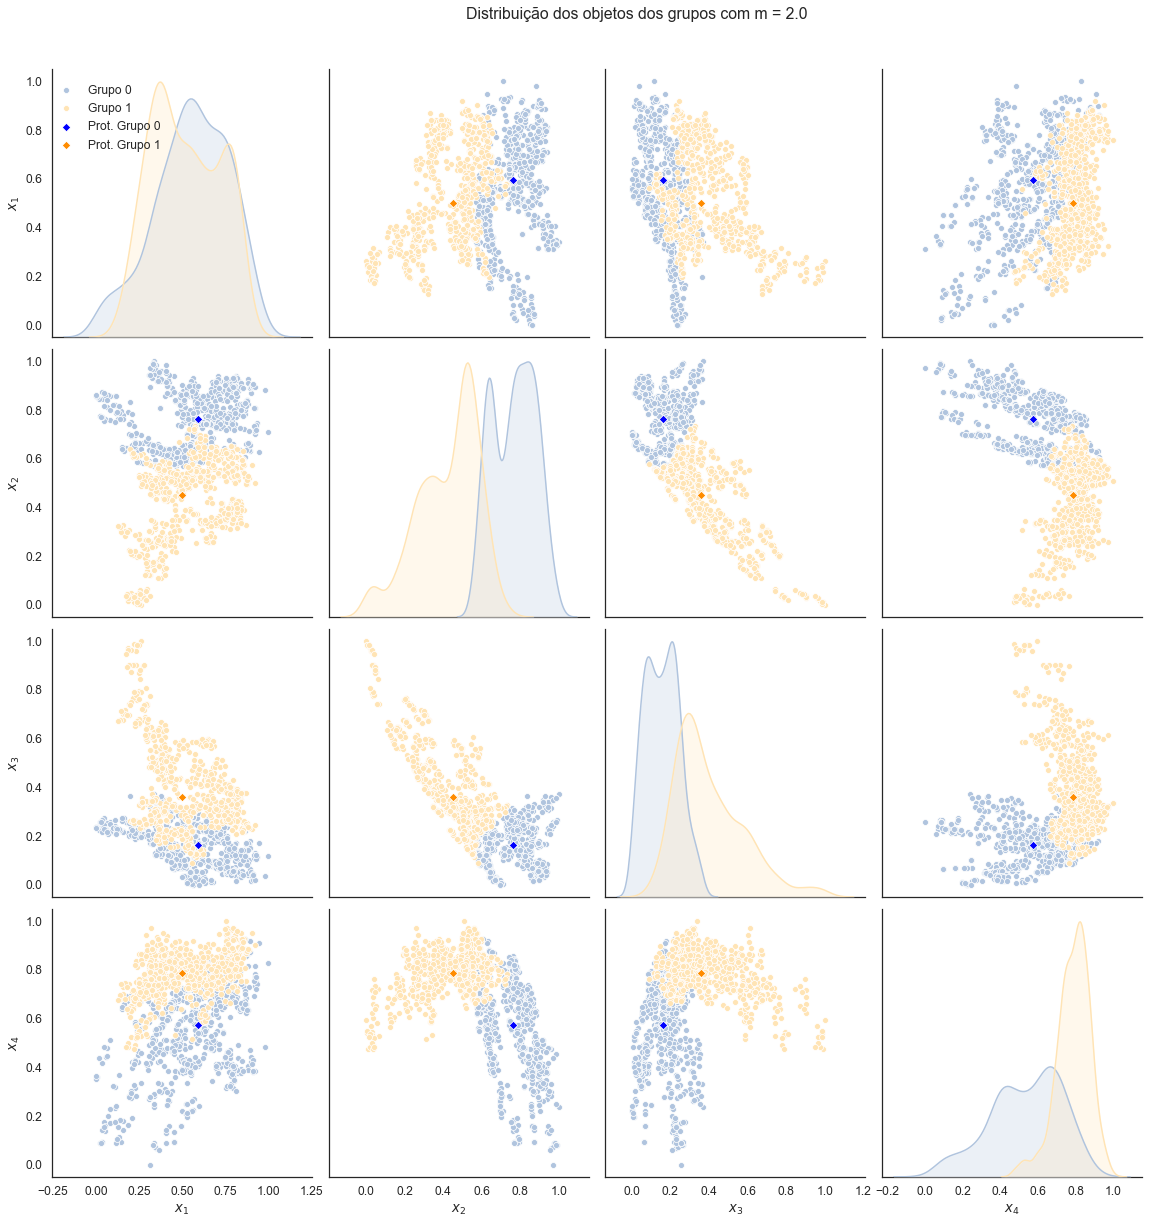

In [181]:
import seaborn as sns
#sns.set_theme(style="ticks")
sns.set(font_scale=1.1, style='white')
for m in [1.1, 1.6, 2.0]:
    v0 = resultados[m]['v'][0]
    v1 = resultados[m]['v'][1]
    prot_0_df = pd.DataFrame({'x1':[v0[0]], 'x2':[v0[1]],'x3':[v0[2]],'x4':[v0[3]], 'Grupo':['Prot. Grupo 0']})
    prot_1_df = pd.DataFrame({'x1':[v1[0]], 'x2':[v1[1]],'x3':[v1[2]],'x4':[v1[3]], 'Grupo':['Prot. Grupo 1']})
    prots_df = pd.concat([prot_0_df, prot_1_df], axis=0, ignore_index=True)
    n_lines = len(objs_clusters[m][0])
    grupo_0_df = pd.concat([pd.DataFrame(objs_clusters[m][0]),pd.DataFrame({'Grupo':['Grupo 0']*n_lines})], axis=1)
    n_lines = len(objs_clusters[m][1])
    grupo_1_df = pd.concat([pd.DataFrame(objs_clusters[m][1]),pd.DataFrame({'Grupo':['Grupo 1']*n_lines})], axis=1)
    grupos_df = pd.concat([grupo_0_df, grupo_1_df, prots_df], axis=0, ignore_index=True)
    grupos_df = grupos_df.rename(columns={'x1':'$x_1$','x2':'$x_2$', 'x3':'$x_3$','x4':'$x_4$', 'Grupo':''})

    pg = sns.pairplot(grupos_df, hue='', markers=["o", "o", "D", "D"], palette=["lightsteelblue", "moccasin", "blue", "darkorange"], height=4)
    pg.fig.suptitle(f'Distribuição dos objetos dos grupos com m = {m}', y = 1.05)
    pg._legend.set_bbox_to_anchor((0.135, 0.96))
    
    plt.savefig(f'grupos_proto_m{m}.png')
    plt.show()
    plt.close('all')

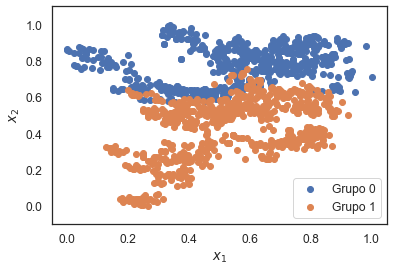

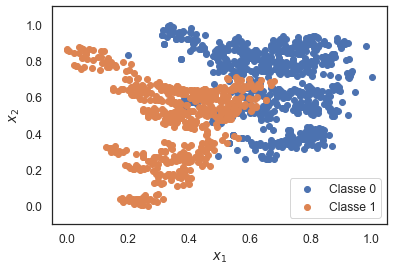

In [120]:
# Plotando os grupos finais para m=1.1:
plt.scatter(objs_clusters[1.1][0]['x1'], objs_clusters[1.1][0]['x2'], label='Grupo 0')
plt.scatter(objs_clusters[1.1][1]['x1'], objs_clusters[1.1][1]['x2'], label='Grupo 1')
plt.ylim(-0.1,1.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.savefig('grupos_m1.1_x1_x2.png')
plt.show()
plt.close('all')


# Plotando as classes com os rótulos originais dos dados:
fig,ax = plt.subplots()
for k,d in df.groupby('class'):
    ax.scatter(d['x1'], d['x2'], label=f'Classe {k}')
plt.ylim(-0.1,1.1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc=0)
plt.savefig('classes_x1_x2.png')
plt.show()
plt.close('all')

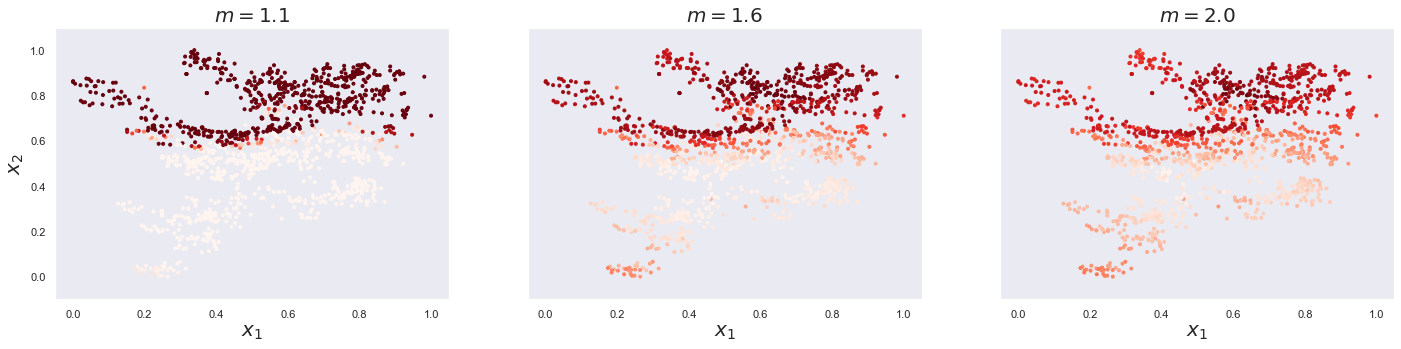

In [180]:
# Plotando o agrupamento fuzzy com cores de acordo com o grau de pertinência
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,5))
axes = axes.flatten()
pos = 0
sns.set(style='dark')
axes[0].set_ylabel('$x_2$', fontsize=20)
for m in [1.1, 1.6, 2.0]:
    u0_df = pd.DataFrame(resultados[m]['u'][0], columns=['$u_0$'])
    X_u_df = pd.concat([df[df.columns[:-1]], u0_df], axis=1)
    axes[pos].scatter(x= X_u_df['x1'], y = X_u_df['x2'], c=X_u_df['$u_0$'], marker = '.', cmap=plt.cm.Reds, alpha=1)
    axes[pos].set_ylim(-0.1,1.1)
    axes[pos].set_xlabel('$x_1$', fontsize=20)
    axes[pos].set_title(f'$m = {m}$', size=20)
    pos += 1
plt.savefig('fuzzy_plot.png')
plt.show()
plt.close('all')